In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import cv2, glob, os, pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from Utilities.Undistort import *

In [3]:
images = glob.glob('../Lane Images/*.jpg')

In [4]:
def undistort(image):
    undistort = Undistort(image, model_path = '../models/')
    return undistort.process()

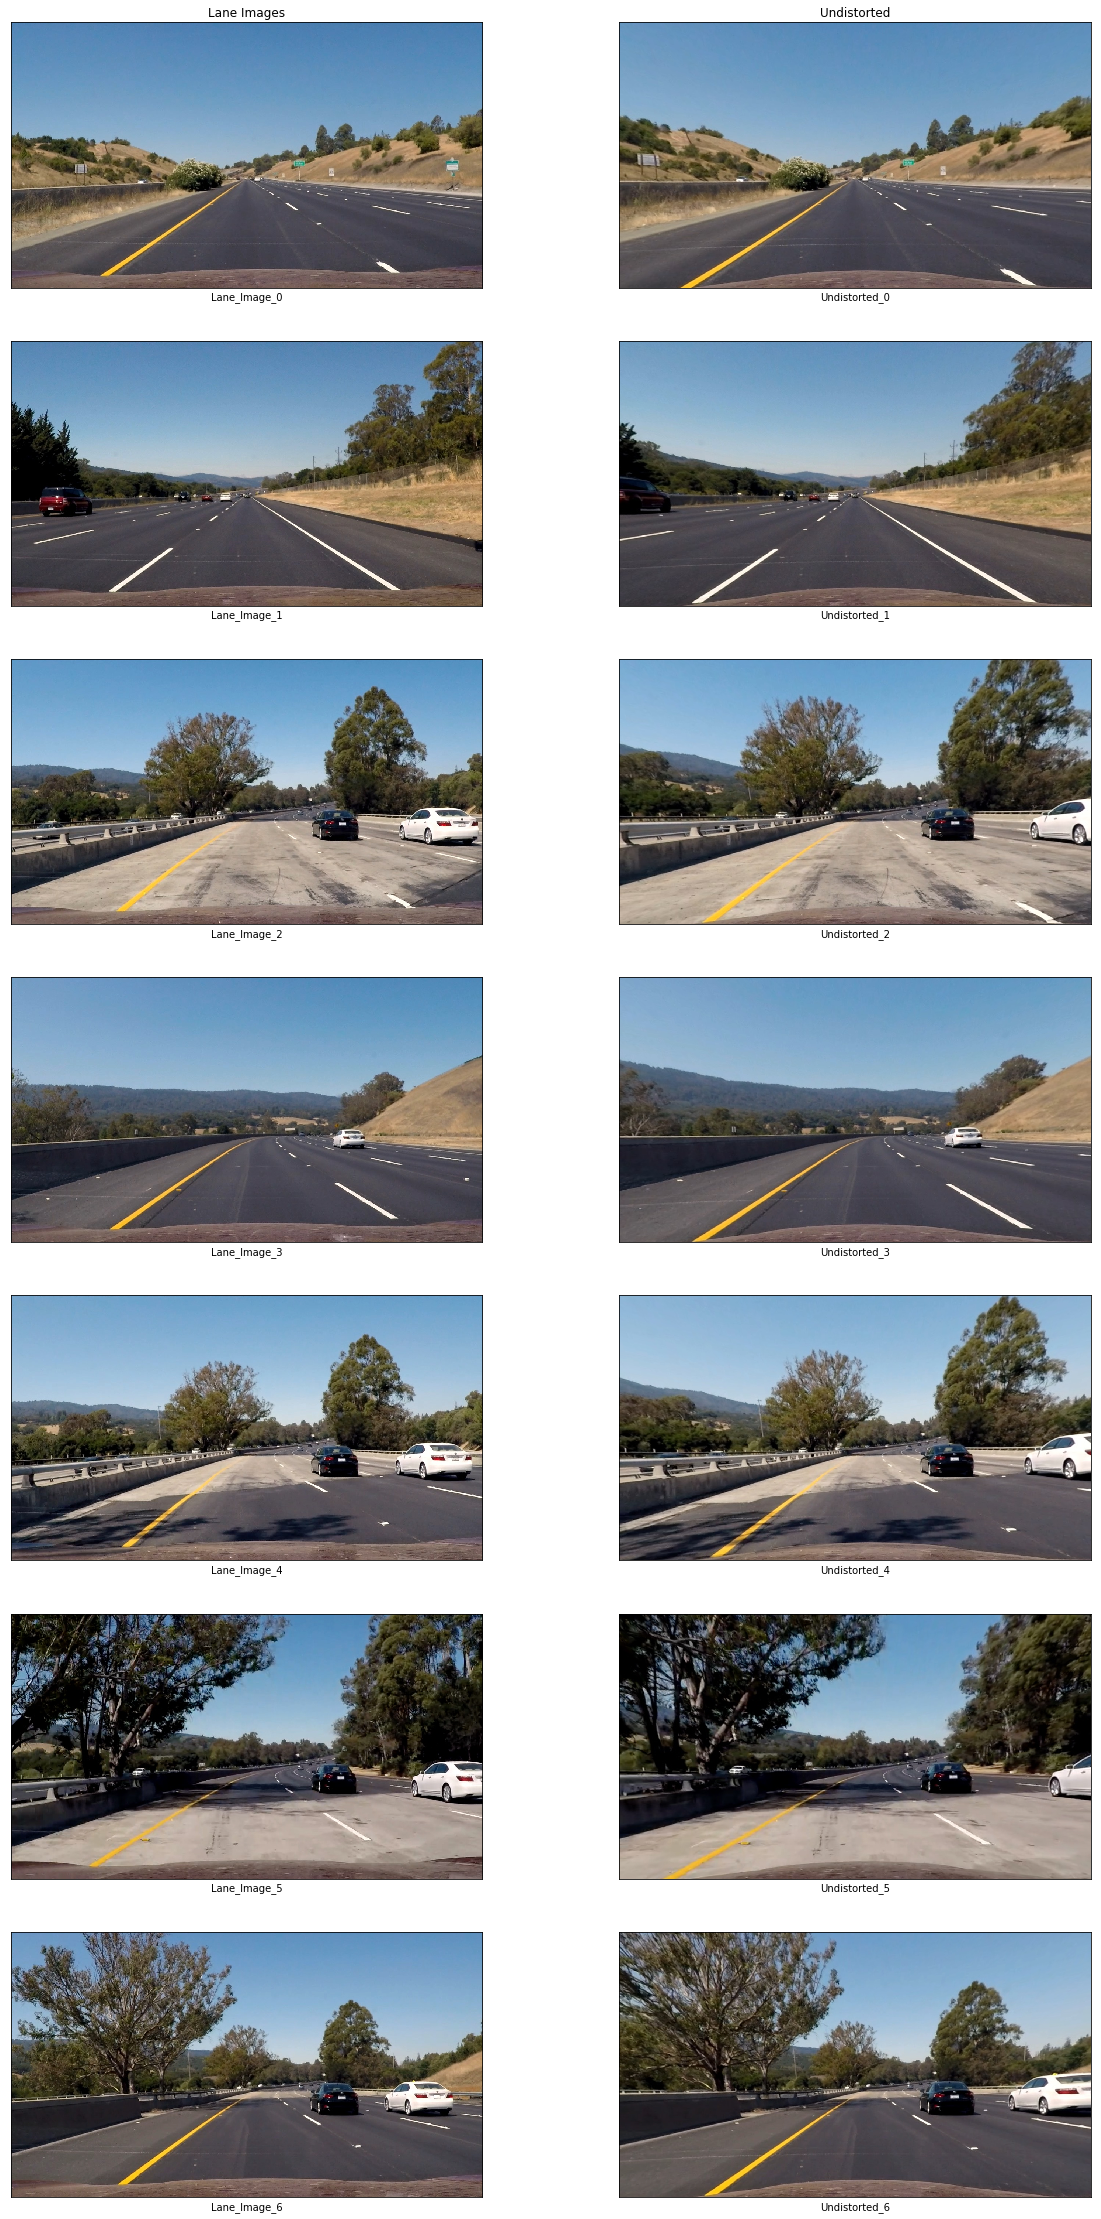

In [5]:
fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Lane Images', 'Undistorted']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    if i % 2 == 0:
        ax.imshow(image)
        ax.set_xlabel('Lane_Image_' + str(c))
    if i % 2 == 1:
        ax.imshow(undistorted)
        ax.set_xlabel('Undistorted_' + str(c))
        c += 1
plt.show()

In [6]:
def get_roi(img, vertices):
    vertices = np.array(vertices, ndmin=3, dtype=np.int32)
    mask = np.zeros_like(img)
    mask = cv2.fillPoly(mask, vertices, (255, 255, 255))
    return cv2.bitwise_and(img, mask)

In [7]:
def warp_image(img, warp_shape, src, dst):
    M = cv2.getPerspectiveTransform(src, dst) # Perspective Transform Matrix
    invM = cv2.getPerspectiveTransform(dst, src) # Inverse Perspective Transform Matrix
    warped = cv2.warpPerspective(img, M, warp_shape, flags = cv2.INTER_LINEAR) # Warping
    return warped, M, invM

In [8]:
def perspective_transform(image):
    y, x, _ = image.shape
    source = np.float32([
        (696, 455),    
        (587, 455), 
        (235, 700),  
        (1075, 700)
    ])
    destination = np.float32([
        (x - 350, 0),
        (350, 0),
        (350, y),
        (x - 350, y)
    ])
    
    image_labelled = image.copy()
    cv2.polylines(image_labelled, [np.int32(source)], True, (255, 0, 0), 3)
    
    warped, M, invM = warp_image(image, (x, y), source, destination)
    warped_labelled = warped.copy()
    cv2.polylines(warped_labelled, [np.int32(destination)], True, (255, 0, 0), 3)
    
    vertices = np.array([
        [200, y],
        [200, 0],
        [1100, 0],
        [1100, y]
    ])
    roi = get_roi(warped, vertices)
    
    return warped, warped_labelled, roi, image_labelled, M, invM

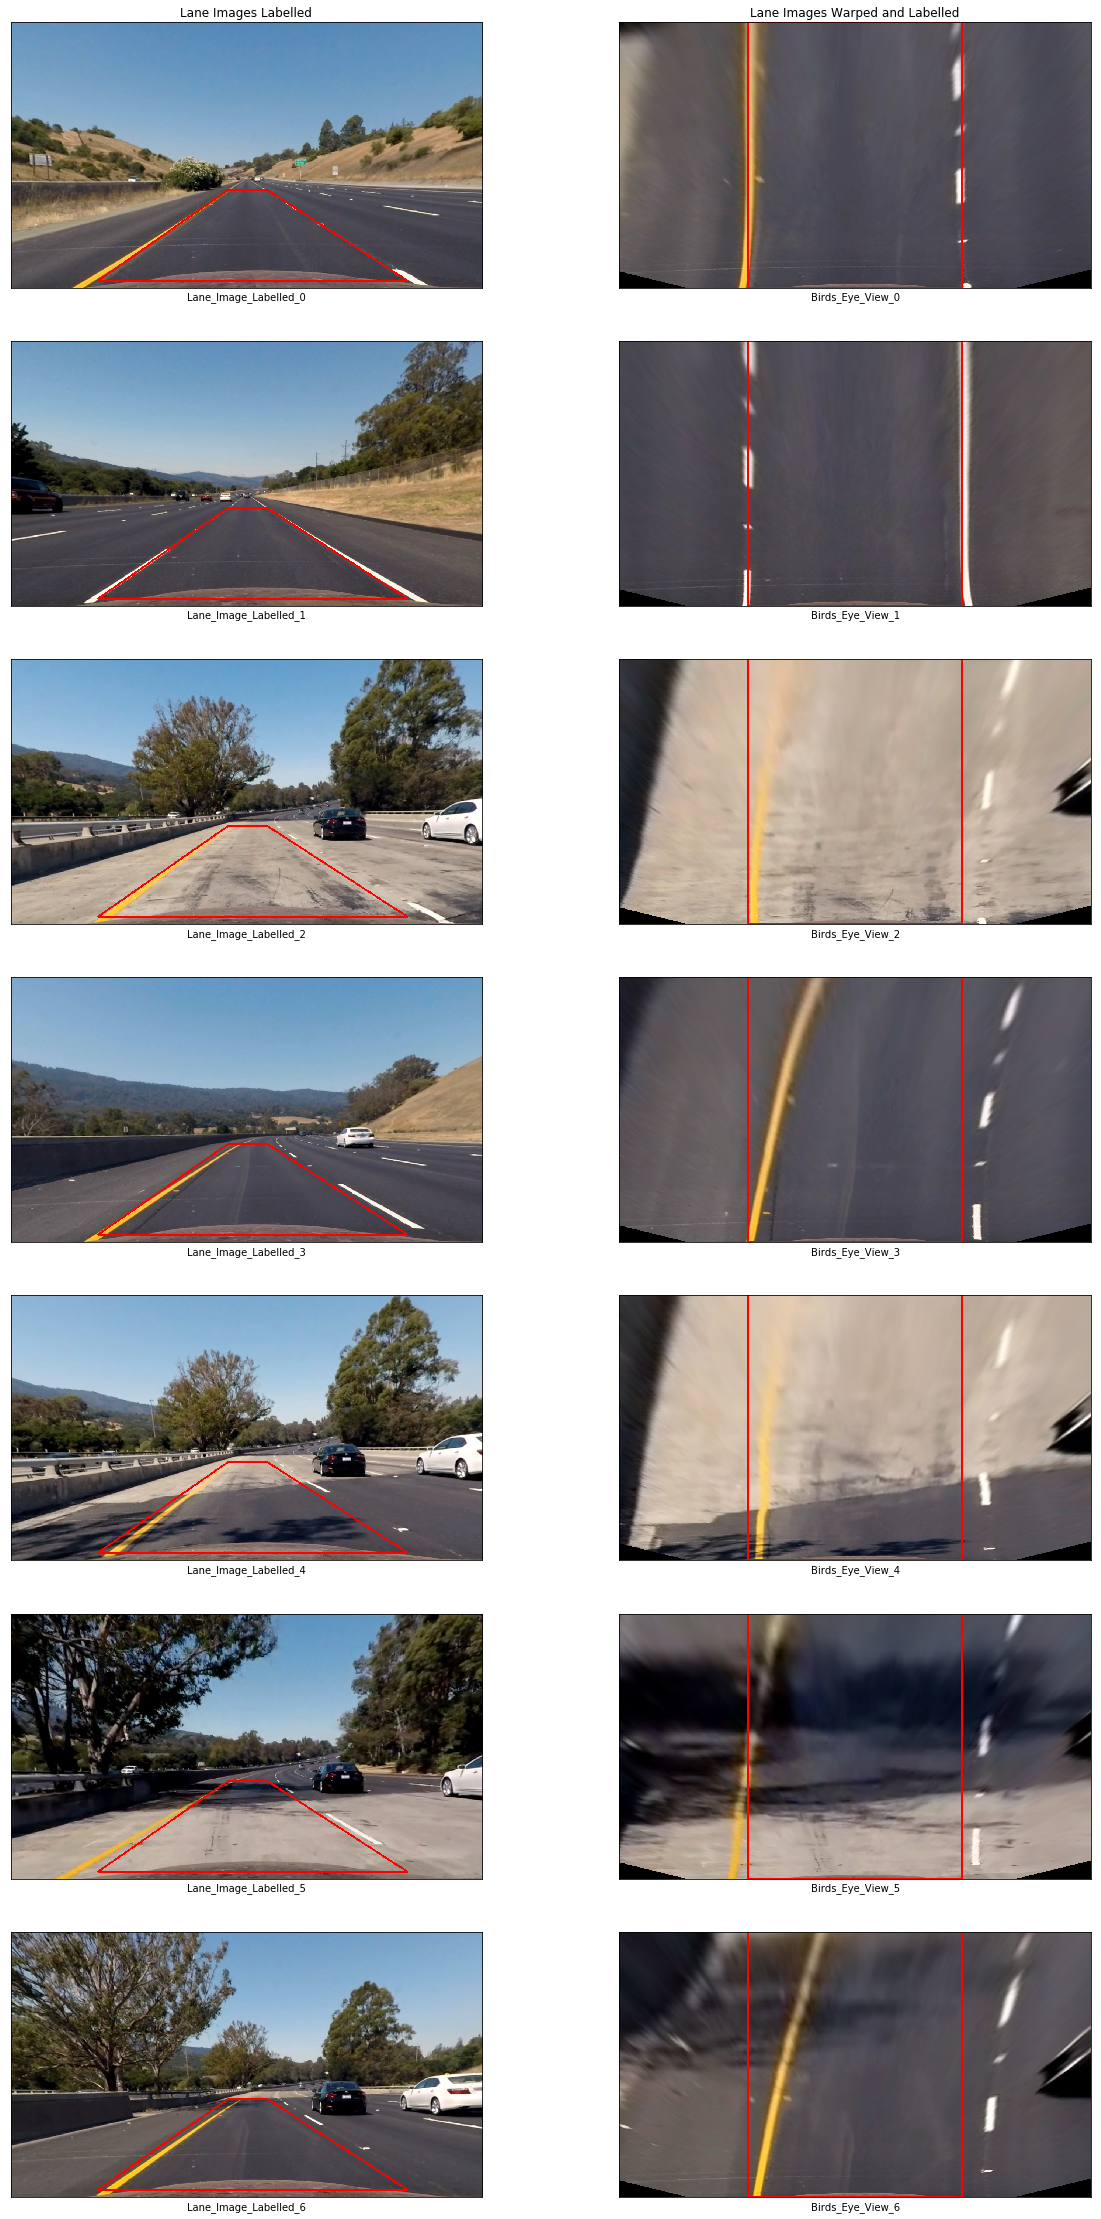

In [9]:
fig, axes = plt.subplots(nrows = len(images), ncols = 2, figsize = (20, 40))
plt.setp(axes.flat, xticks = [], yticks = [])
c = 0
for ax, col in zip(axes[0], ['Lane Images Labelled', 'Lane Images Warped and Labelled']):
    ax.set_title(col)
for i, ax in enumerate(axes.flat):
    image = mpimg.imread(images[c])
    undistorted = undistort(image)
    warped, warped_labelled, roi, image_labelled, M, invM = perspective_transform(undistorted)
    if i % 2 == 0:
        ax.imshow(image_labelled)
        ax.set_xlabel('Lane_Image_Labelled_' + str(c))
    if i % 2 == 1:
        ax.imshow(warped_labelled)
        ax.set_xlabel('Birds_Eye_View_' + str(c))
        c += 1
plt.show()